# Introduction

This report provides an overview for the Python package `scicomp` produced for this unit. `scicomp` provides functionality for solving non-stiff ordinary differential equations (ODEs), solving selected partial differential equations (PDEs), finding periodic orbits in ODEs, and tracking steady state solutions and periodic orbits. The design decision taken in producing this package and a reflective learning log are also presented.

# Demonstration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science"])
%config InlineBackend.figure_format = 'svg'

import scicomp

## Initial Value Problem (IVP) Solvers

The foundation of the package is `scicomp.integrate.solve_ivp`, which provides functionality for find the solution to IVPs. `solve_ivp` implements the following different explicit Runge-Kutta methods:

In [2]:
print(", ".join(scicomp.integrate._all_methods.keys()))

euler, midpoint, heun, ralston, kutta3, heun3, wray3, ralston3, ssprk3, rk4, rk38, ralston4, bogacki_shampine, rkf45, ck45, dopri45


These methods can operate in two modes as specified by the user, either using a fixed timestep or an adaptive timestep. In adaptive mode, the timestep is adjusted such that the estimated local error satisfies the user specified absolute and relative tolerance using the method described by Hairer and Wanner [1]. The method for estimating the local error depends on the Runge-Kutta method used. Methods such as Runge-Kutta-Fehlberg and Dormand-Prince contain an embedded error estimate in their Butcher tableau. For methods such as Euler's method or the classic fourth order Runge-Kutta the local error is estimated using Richardson Extrapolation as described in [1]. The initial step size for the adaptive mode can either be specified by the user or selected automatically using the method described in [1].

To demonstrate the capabilities of the IVP solver we will consider the ordinary differential equation (ODE) for the modified Hopf bifurcation normal form

\begin{align}
  \frac{\mathrm{d}u_1}{\mathrm{d}t} &= \beta u_1 - u_2 + u_1\left(u_1^2 + u_2^2\right) - u_1\left(u_1^2 + u_2^2\right)^2,\\
  \frac{\mathrm{d}u_2}{\mathrm{d}t} &= u_1 + \beta u_2 + u_2\left(u_1^2 + u_2^2\right) - u_2\left(u_1^2 + u_2^2\right)^2.
\end{align}

This ODE is provided as part of the collection of common ODEs in the `scicomp.odes` submodule. Below is demonstration of solving ODE with initial conditions $u_1(0)=1$ and $u_2(0)=-1$, parameter $\beta=1$ from $t=0$ to $t=40$. The default solver Runge-Kutta-Fehlberg is used in adaptive mode (default mode) with a relative tolerance of 1e^-6 and an absolute tolerance of 1e^-6 (default value).

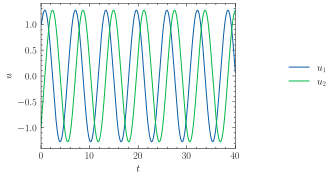

In [3]:
from scicomp.integrate import solve_ivp
from scicomp.odes import modified_hopf

ode_sol = solve_ivp(modified_hopf, y0=[1, -1], t_span=(0, 40),
                    ode_params={"beta": 1}, r_tol=1e-6)

# Plot solution
fig, ax = plt.subplots()
ax.plot(ode_sol.t, ode_sol.y[0, :], label="$u_1$")
ax.plot(ode_sol.t, ode_sol.y[1, :], label="$u_2$")
ax.set_xlabel("$t$"); ax.set_ylabel("$u$"); ax.set_xlim([0, 40])
ax.legend(loc="right", bbox_to_anchor=(1.3, 0.5), bbox_transform=fig.transFigure);

## Numerical Shooting

The above solution appears to contain a periodic orbit. `scicomp.shooting.find_limit_cycle` provides functionality to isolate periodic orbits in ODEs. Functionality is provided to specify an exact value as the phase condition, a derivative phase condition or the user is able to define their own phase condition.

In the demonstration below we will find the periodic orbit in the above solution of the modified Hopf normal form with a derivative phase condition such that

$$
\frac{\mathrm{d}u_1}{\mathrm{d}t}(0)=0.
$$

In [4]:
from scicomp.shooting import find_limit_cycle, DerivativePhaseCondition

# define phase condition st. u_1'(0) = 0
pc = DerivativePhaseCondition(0)

orbit_sol = find_limit_cycle(modified_hopf, y0=[1, -1], T=5, phase_condition=pc,
                             ode_params={"beta": 1})

print(f"Periodic orbit given by intial conditions {orbit_sol.y0} with period {orbit_sol.T}.")

Periodic orbit given by intial conditions [ 1.27298083 -0.00711505] with period 6.285279532095402.


As expected this gives an orbit with a period of $2\pi$.

## Numerical Continuation

The above solution gave a periodic orbit for $\beta = 1$ but how does this change as $\beta$ is varied? `scicomp.continuation.numerical_continuation` allows users track how a steady state or periodic orbit changes as a parameter is varied either using natural parameter continuation or pseudo-arclength continuation. An optional discretisation can be provided to track periodic orbits instead of steady states (the default behaviour). This discretisation provided by `scicomp.shooting.limit_cycle_shooting_func` can be used or a different user defined discretisation can be used.

In the example below we will track the period orbit in the modified hopf normal form as we vary $\beta$ using pseudo-arclength continuation.

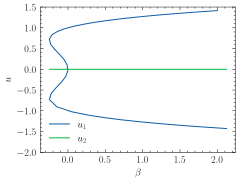

In [5]:
from scicomp.continuation import numerical_continuation
from scicomp.shooting import limit_cycle_shooting_func

continuation_res = numerical_continuation(equation=modified_hopf,
    variable_kwarg="beta", initial_value=2, y0=[1, 1, 6],
    step_size=-0.1, max_steps=47, discretisation=limit_cycle_shooting_func,
    discretisation_kwargs={
        "phase_condition": pc,
        "ivp_solver_kwargs": {"r_tol": 1e-6},
    })

fig, ax = plt.subplots()
ax.plot(continuation_res.parameter_values, continuation_res.state_values[0, :], label="$u_1$")
ax.plot(continuation_res.parameter_values, continuation_res.state_values[1, :], label="$u_2$")
ax.set_xlabel(r"$\beta$"); ax.set_ylabel("$u$"); ax.set_ylim([-2, 1.5]); ax.legend();

As expected this is able to track the location of the perodic orbit of a range of $\beta$.

To demonstrait tracking the steady states of an ODE, consider

\begin{equation}
  \frac{\mathrm{d}x}{\mathrm{d}t} = x^3 - x + c,
\end{equation}

where $c$ is the parameter to vary.

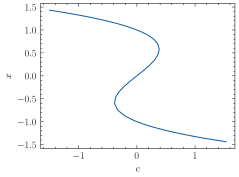

In [6]:
def equation(x, c):
    return x**3 - x + c


continuation_res = numerical_continuation(equation, variable_kwarg="c",
                                          initial_value=-1.5, step_size=0.1,
                                          max_steps=45, y0=[1.5],
                                          root_finder_kwargs={"tol": 1e-8},method="ps-arc")

fig, ax = plt.subplots()
ax.plot(continuation_res.parameter_values, continuation_res.state_values[0, :])
ax.set_xlabel("$c$")
ax.set_ylabel("$x$");

## Boundary Value Problems (BVPs)

To aid solving boundary value problems `scicomp` implement functions for finite difference method and convenience functions for common BVPs. For example, consider the steady state Bratu problem

\begin{align}
D u_{xx} + e^{\mu u} = 0, \qquad u(0) = u(1) = 0,
\end{align}
when $D = 1.0$ and $\mu = 0.1$.

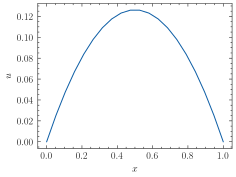

In [8]:
from scicomp.finite_diff import DirichletBC, Grid
from scicomp.bvps import solve_nonlinear_poisson_eq

D = 1
mu = 0.1

# define the boundary conditions
left_bc = right_bc = DirichletBC(0)

# define the domain
grid = Grid(a=0, b=1, N=20, left_BC=left_bc, right_BC=right_bc)

# solve using convenience function
bratu_sol = solve_nonlinear_poisson_eq(u0=np.ones_like(grid.x_inner), grid=grid, D=D, q=lambda u, x: np.exp(mu * u))

fig, ax = plt.subplots()
ax.plot(grid.x, bratu_sol)
ax.set_xlabel("$x$"); ax.set_ylabel("$u$");

For BVPs where there is not a pre-implemented convenience function it is possible to solve the problem using the individual finite difference functions instead. As an example, consider the steady reaction-convection-diffusion equation

\begin{equation}
D u_{xx} -vu_{x} + q(x) = 0,
\end{equation}

where $D=0.01$, $v=1$, $q(x)=1$ and $u(0)=u(1)=0$. The following shows how this would be solved using a central difference approximation for both derivatives.

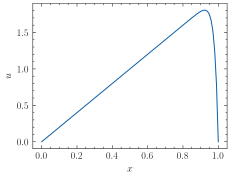

In [11]:
from scicomp.finite_diff import get_A_mat_from_BCs, apply_BCs_to_soln

# define the boundary conditions
left_bc = right_bc = DirichletBC(0)

# define the domain
grid = Grid(a=0, b=1, N=100, left_BC=left_bc, right_BC=right_bc)

D = 0.01
v = 1
q = np.ones_like(grid.x_inner)

A_1 = get_A_mat_from_BCs(2, grid=grid)
A_2 = get_A_mat_from_BCs(1, grid=grid)
# as BCs are zero no b vector is needed, normally this would be created with: b = get_b_vec_from_BCs

sol = np.linalg.solve(D * A_1 - 0.5 * v * grid.dx * A_2, -grid.dx**2 * q)

fig, ax = plt.subplots()
ax.plot(grid.x, apply_BCs_to_soln(sol, grid=grid))
ax.set_xlabel("$x$"); ax.set_ylabel("$u$");

## PDEs

The first method of solving PDEs offered by `scicomp` is the method of lines. As a demonstration consider the dynamic Bratu problem

\begin{align}
u_t = D u_{xx} + e^{\mu u}, \qquad u(0) = u(1) = 0,
\end{align}
when $D = 1.0$ and $\mu = 0.1$. We will see how the dynamic problem approaches the steady state determined in the previous demonstration.

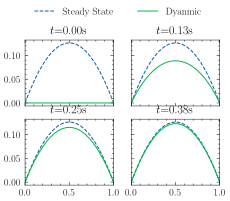

In [12]:
from scicomp.pdes import solve_diffusion_method_lines

D = 1
mu = 0.1

# define the boundary conditions
left_bc = right_bc = DirichletBC(0)

# define the domain
grid = Grid(a=0, b=1, N=20, left_BC=left_bc, right_BC=right_bc)

dynamic_bratu_sol = solve_diffusion_method_lines(grid=grid,D=D,
    u0_func=lambda x: np.zeros_like(x),
    q=lambda u, x, t: np.exp(mu * u), t_span=[0, 0.5])

fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

for i, ax in enumerate(axs.reshape(-1)):
    i = int(i * dynamic_bratu_sol.t.size // 4)
    ax.set_title(f"$t$={dynamic_bratu_sol.t[i]:.2f}s")
    ax.plot(grid.x, bratu_sol, "--")
    ax.plot(grid.x, dynamic_bratu_sol.u[i, :])

plt.setp(axs, xlim=[0, 1])
labels = ["Steady State", "Dynamic Solution"]
fig.legend(["Steady State", "Dyanmic"], ncols=2, loc="upper center",
    bbox_to_anchor=(0.5, 1.1), bbox_transform=fig.transFigure);

- ADD axis labels to above figure
- Solve the same using CN
- Do PDE continuation

# Design Decisions

The `scicomp` package is intended to be production quality code. This means all items of the public API have full docstrings, many have example usage. All docstrings have been written in the [numpydoc](https://numpydoc.readthedocs.io/en/latest/format.html) format. This means if the package was to be published documentation could automatically generated using [Sphinx](https://www.sphinx-doc.org/en/master/). Furthermore, all items in the public API have unit tests to ensure that the code functions as expected and gives the same results as analytical methods. The unit tests are automatically executed when new commits are push to GitHub using the GitHub action continuous integration (CI) platform. Furthermore, the docstring examples are also checked using doctesting in the CI job. Multiple versions of Python are used to during the CI test run to ensure the code is compliant with the [NEP 29](https://numpy.org/neps/nep-0029-deprecation_policy.html) standard. There in an additional CI job which runs a linter to check compliance with the [PEP 8](https://peps.python.org/pep-0008/) style guide and to detect common back practices. Type hints are provided for all functions in accordance with [PEP 483](https://peps.python.org/pep-0483/) as this provides an additional form of documentation, helps IDEs provide better suggestions and can catch errors relating to incorrect types. The correctness of these type hints are check in a CI job using the static type checker Mypy.

The public API for the `scicomp` package has been designed to easy to extend and maintain. For example, where functions are required to return multiple results, results objects are used instead of returning tuples. This means that if new features are added in the future it is possible return more results from the function by adding to the results object whereas if the function returned a longer tuple this would be backwards incompatible.

A common programming principle is "Don't repeat yourself" (DRY). This aims to reduce repetition by using abstraction. However this added abstraction has the potential to pollute the API with functions/classes/methods which are not designed for public consumption. Therefor, to designate this, functions which are named with a leading underscore are intended to be private with everything else being part of the public API. An example of where this has been applied is the `_error_norm` function which is used throughout the IVP solver.

The submodules and functions are designed to be composable with each other in order to create new functionality. An example of is the numerical continuation function which is composed from the IVP solver and the shooting function. This reduces code duplication and also allows the user to replace and extend components of the code base with code they have written. For example it is possible replace the IVP solver used in the shooting component with the solver from SciPy. This is useful as SciPy offers methods for solving stiff ODEs whereas `scicomp` does not.

Where possible `scicomp` tries to use Numpy arrays, universal functions and operator broadcasting to avoid for loops. This improves the performance as the looping then occurs in low level language and operations can leverage the single instruction, multiple data (SIMD) instruction set. Further, Numpy arrays use less memory than Python lists as they are stored as contiguous arrays whereas a Python list is an array of pointers to other objects. Numpy arrays are stored in memory using the row-major order by default meaning the rows of an array are contiguous in memory. This means it is faster to access a row of a Numpy array (as all elements are close in memory) than the columns. In situations where for loops are unavoidable (such as advancing the solution using Crank-Nicolson) they have been carefully designed to loop over the rows of the array so that they access a contiguous slice of memory, which improves the performance of the code.

When designing `scicomp.integrate.solve_ivp` it was decided to define all stepping methods in terms of their Butcher tableau rather than writing unique code for each method.
\begin{equation}
\begin{array}
{c|c}
\mathbf{c}& \mathbf{A}\\
\hline
& \mathbf{b}
\end{array}.
\end{equation}
This was decided as, for any explicit $s$ stage Runge-Kutta method, a time step can be defined as
\begin{equation}
y_{n+1} = y_{n} + h\sum_{i=1}^{s}b_ik_i,
\end{equation}
where
\begin{equation}
k_i = f(x_i + c_i h, y_i + h\sum_{j=1}^{i-1}a_{s,j}k_j) \ [1].
\end{equation}
This reduces code duplication and makes the package easy to extend as the only requirement for adding a new method is the define the entries of the Butcher Tableau. This is done by creating a concrete subtype of the abstract class `scicomp.integrate._RungeKuttaStep`.

Due to time constraints in producing this package, some simplification have been made IVP solvers compared to the solver found in SciPy/MATLAB. For example, `scicomp.integrate.solve_ivp` can only integrate forward in time. This decision was made as this package is designed for studying dynamical systems where typically the solution forwards in time is of interest.

Another simplification is the form in which the solution is output. If the fixed timestep mode is used the outputted solution is given at regular intervals. However this is not the case if an adaptive step size is used. This means if the user requires the solution at specific times they are forced to use the less efficient fixed timestep mode. An improvement would be to provide the option for a dense output which uses an interpolating polynomial to cheaply evaluate the solution at specified times. However as shooting and continuation are mostly depended on the final value of solution opposed to the intermediate values it was decided not to implement a dense output.

The methods with embedded error estimates are designed such that function evaluations from the previous step can be reused in the next step. This property is called first same as last (FSAL). For example, the Dormand–Prince method can be calculated using six function evaluations per step despite have seven steps. This is useful if the right hand side function of the ODE is expensive to evaluate. However, as none of the ODEs used with this package are very complicated, for simplicity `scicomp.integrate.solve_ivp` does not implement FSAL.

As methods for solving PDEs are not as general as those for solving IVPs, this require careful design to create a reusable set of components that could be combined to solve a range of PDE problems. In general, this starts by defining the boundary condition objects and then the `Grid` object, which defines the discretisation of the domain. From here it is possible create the finite difference matrices and boundary condition vectors that are necessary to construct many of the methods. Common BVPs and PDEs have convenience function defined in `scicomp.bvps` and `scicomp.pdes` respectively that automatically setup the problem for the user. This design was chosen as it reduces code duplication and abstracts the need to worry about details such as finite difference coefficients from the user.

For solving Poison's equation, there is both `scicomp.bvps.solve_linear_poisson_eq` for Poisson's equation with linear source terms and `scicomp.bvps.solve_nonlinear_poisson_eq` for non-linear source terms. The linear version solves a linear system of equations whereas the nonlinear version uses root finding. The reason for including both despite the fact all linear source terms can also be solved using the non-linear function is because solving linear systems is generally faster than root finding. We can confirm this using benchmarking.

In [15]:
from timeit import timeit

setup = """
import numpy as np
from scicomp.finite_diff import DirichletBC, Grid
from scicomp.bvps import solve_nonlinear_poisson_eq, solve_linear_poisson_eq
D=1
left_bc = DirichletBC(0)
right_bc = DirichletBC(10)
grid = Grid(a=0, b=1, N=1000, left_BC=left_bc, right_BC=right_bc)
"""

nonlin = """
solve_nonlinear_poisson_eq(u0=np.linspace(0, 10, num=grid.N_inner), grid=grid, D=D, q=lambda u, x: np.ones_like(x))
"""
lin = """
solve_linear_poisson_eq(grid=grid, D=D, q=lambda x: np.ones_like(x))
"""

linear_solve_time = timeit(stmt=lin, setup=setup, number=10)
nonlinear_solve_time = timeit(stmt=nonlin, setup=setup, number=10)
print(f"{linear_solve_time=}, {nonlinear_solve_time=}")

linear_solve_time=0.25730390404351056, nonlinear_solve_time=9.33865013497416


Here we see that `solve_linear_poisson_eq` is over ten times faster for the same problem. We can confirm that root finding is where most of the time is spent in `solve_nonlinear_poisson_eq` using profiling.

In [16]:
import cProfile, pstats

exec(setup)
pr = cProfile.Profile(builtins=False)
pr.run(nonlin)
pstats.Stats(pr).strip_dirs().sort_stats("tottime").print_stats(5);

         11371 function calls in 1.875 seconds

   Ordered by: internal time
   List reduced from 143 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.789    1.789    1.868    1.868 _minpack_py.py:184(_root_hybr)
     1004    0.065    0.000    0.079    0.000 bvps.py:134(eq)
     1008    0.004    0.000    0.004    0.000 <__array_function__ internals>:177(copyto)
     1007    0.003    0.000    0.003    0.000 <__array_function__ internals>:177(empty_like)
        1    0.002    0.002    0.002    0.002 _compressed.py:1048(toarray)




As expected we see that the majority of time is spent in `_minpack_py.py` which is part of the SciPy root finding function. The performance difference between these two functions could be further increased by exploiting the tridiagonal structure of the linear system when solving. Current it uses`scipy.linalg.solve` to solve the system, which in turn uses the `dgesv` LAPACK routine to solve the system using LU factorisation with partial pivoting. Instead, as the system is tridiagonal either Thomas' algorithm or the `dgtsv` LAPACK routine, which is designed specifically for tridiagonal systems, could be used to improve performance.

# Reflective Learning Log

During past units, such as Numerical Methods in MATLAB, I had been introduced to and implemented Runge-Kutta methods for solving IVPs. However these implementations always used a fixed time step. This often results in wasted computation as the same time step is used even when the ODE is easy to integrate. During this coursework I have implemented an adaptive step size algorithm for the first time, both using Richardson extrapolation and an embedded error estimate. This has given me a better under standing of how function such as SciPy's `solve_ivp` or MATLAB's `ODE45` work which will be useful in the future for debugging a failed solve. In implementing an adaptive time step I became familiar with reference literature such as Hairer and Wanner [1], and Butcher [2]. This has broaden my understanding of numerical methods for solving ODEs. For example, I was previously not familiar with the initial step size selection algorithm that I implemented.

During this project I have also developed an appreciation for what is required to develop a robust numerical code. For example, when I first implemented the adaptive step size solver it functioned as expected in most cases however had division by zero issues in the edge case that the initial conditions or the RHS function were zeros. To fix this a had to add extra checks to my code. From this I learnt a valuable lesson that often theoretical descriptions of numerical algorithms in the literature maybe require additional checks and error handling to deal with edge cases that may occur during real world use.

This project was the first time I have configured GitHub Actions from scratch. Whilst I have previously used the Gitlab and Azure CI platforms, learning the specific configurations for GitHub Action is especially useful do to the free minutes offered. This means it will be possible to use Github Actions to automate the execution of my unit tests on future projects for free. Furthermore, starting the project from scratch gave me full control over the toolchain used. This allowed me to experiment with new tools such as Ruff, the linter used.

Developing many of the functions for my package was a two stage process. First, I had to work out how to implement the numerical algorithm. Then, I had to work out how to integrate it with the rest of the functionality in the package. Especially for functions with complex interfaces, such as the numerical continuation function, trying to do these two steps simultaneously was challenging. Instead, I found it easier to first create a rough implementation of the numerical algorithm without worrying about abstraction, code duplication or other best practices. Once I was happy with how the method worked, I would then iterate on this prototype to develop the final API. I found this an easier way of working as, until you understand the method, it is difficult to decide how you want the user to interact with it.

In the short term, I intend to use what I have learnt on this unit during my MDM projects as they often involve collaborative aspect. This put a emphasis on have clear and concise code as multiple people have to work with the code base. Further, MDM results are often based on numerical simulations so ensuring code correctness is essential to avoiding spurious results. Hence, unit testing and continuous integration, as used in this project, will be very useful. Longer term, I invisage the best practices learnt in this unit to be useful while working on my master's thesis. I also hope to use some of the skills learnt to contribute to open source software.

If I was doing this project again I would look at how I could improve the performance of the key components of the package. The main candidates for this would be where for looping is unavoidable, for example the IVP solver. Here the performance could be improved by using a second faster language such as Cython or C++ using PyBind11 to generate Python bindings. This would have helped me to develop new skills as I am less familiar with these languages.

# Conclusion

This report has demonstrated a range of functionality offered by the `scicomp` package such as ODE/PDE solvers, and numerical continuation and shooting. Design decisions, such as define all Runge Kutta methods in terms of their Butcher Tableau, and reflection on the project have also been discussed.

# References

[1] Hairer, E. and Wanner, G. (1991) Solving Ordinary Differential Equations II: Stiff and Differential-Algebraic Problems. Springer, Berlin.
http://dx.doi.org/10.1007/978-3-662-09947-6

[2] Butcher, J.C. (2008) Numerical Methods for Ordinary Differential Equations. 2nd Edition, John Wiley & Sons, Ltd., Chichester.
http://dx.doi.org/10.1002/9780470753767